In [52]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
import pandas as pd

from plotter import *

In [53]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [54]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [55]:
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/'+str(year)+'_templates.pkl'
if os.path.isfile(picklename):
    repickle=False

In [56]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vbf'].scale(scale_lumi, 'dataset')
    templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [57]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb')).integrate('region','signal').integrate('systematic','nominal')

In [58]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [59]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [60]:
templates

<Hist (process,pt1,msd1,ddb1,deta,mjj) instance at 0x7f7a12b8c6d0>

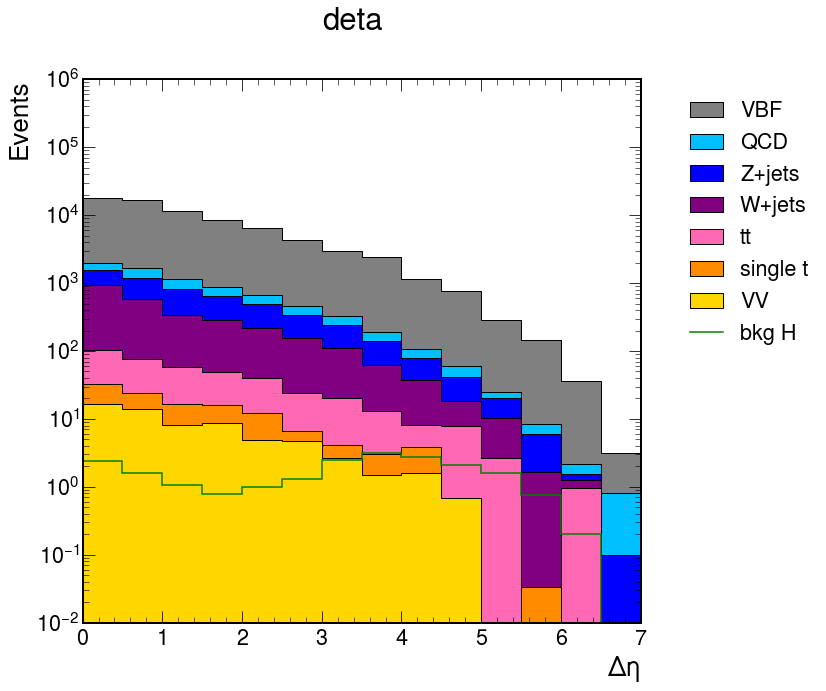

In [61]:
plot_mconly_vbf(templates.sum('pt1','mjj','msd1').integrate('ddb1',int_range=slice(0.89,1)),'deta','deta')

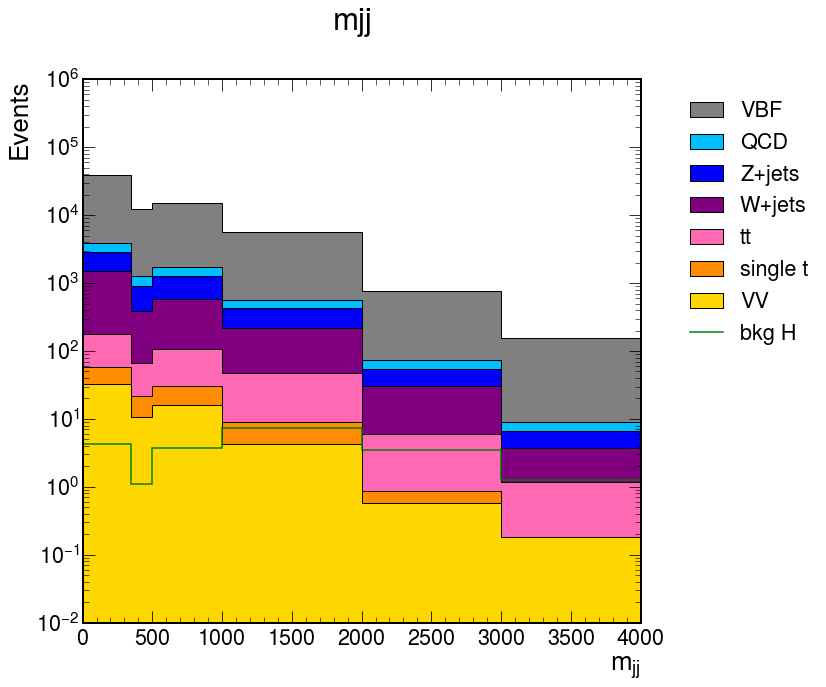

In [62]:
plot_mconly_vbf(templates.sum('deta','msd1','pt1').integrate('ddb1',int_range=slice(0.89,1)),'mjj','mjj')

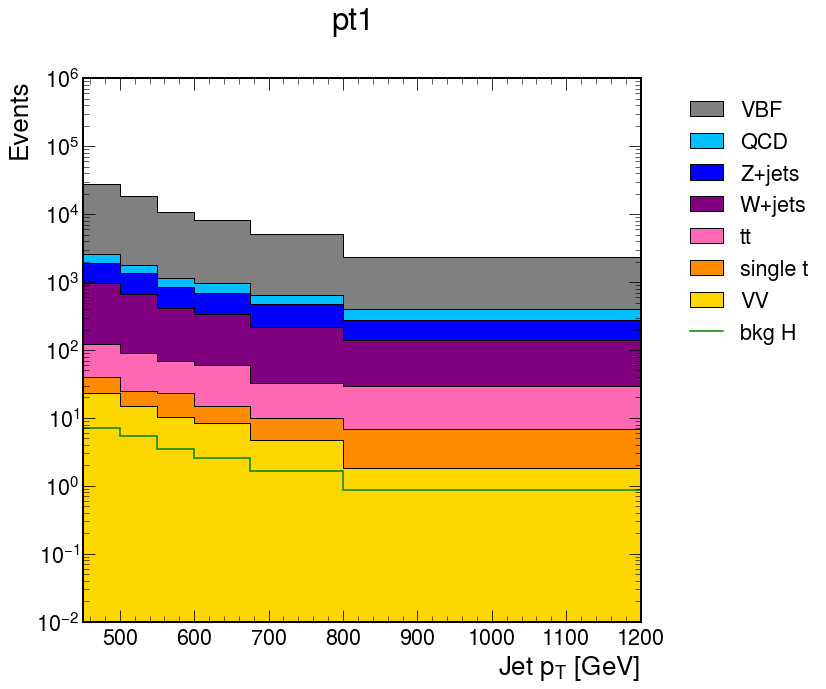

In [63]:
plot_mconly_vbf(templates.sum('deta','mjj','msd1').integrate('ddb1',int_range=slice(0.89,1)),'pt1','pt1')

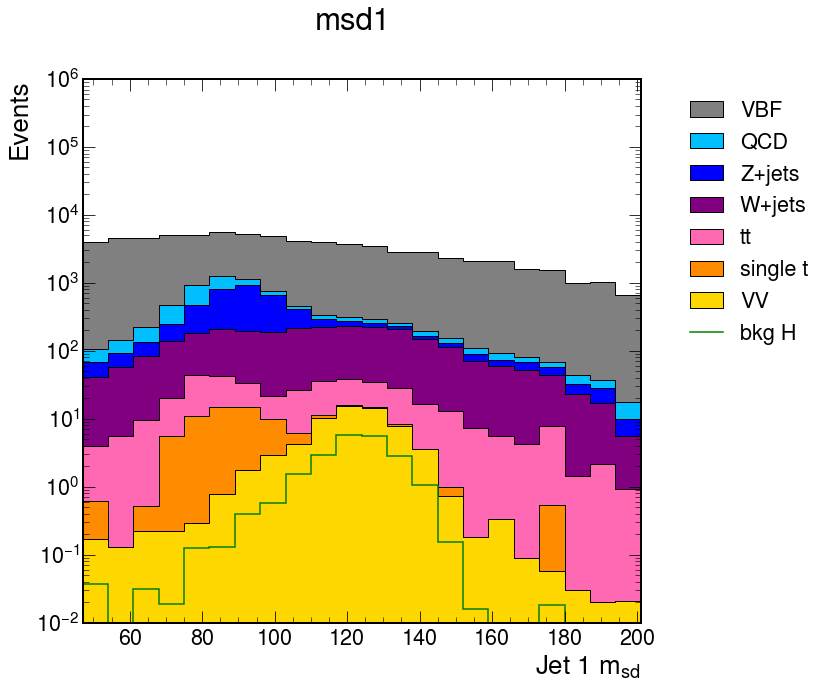

In [64]:
plot_mconly_vbf(templates.sum('deta','mjj','pt1').integrate('ddb1',int_range=slice(0.89,1)),'msd1','msd1')

In [65]:
templates_window=templates.sum('pt1').integrate('msd1',int_range=slice(mbb_min,mbb_max)).integrate('ddb1',int_range=slice(0.89,1))

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f7a12bfddf0>: requested start 200 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f7a12bfddf0>: requested start 400 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f7a12bfddf0>: requested start 600 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f7a12bfddf0>: requested start 800 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-pa

0.35340991217397166
[1000.     3.5]


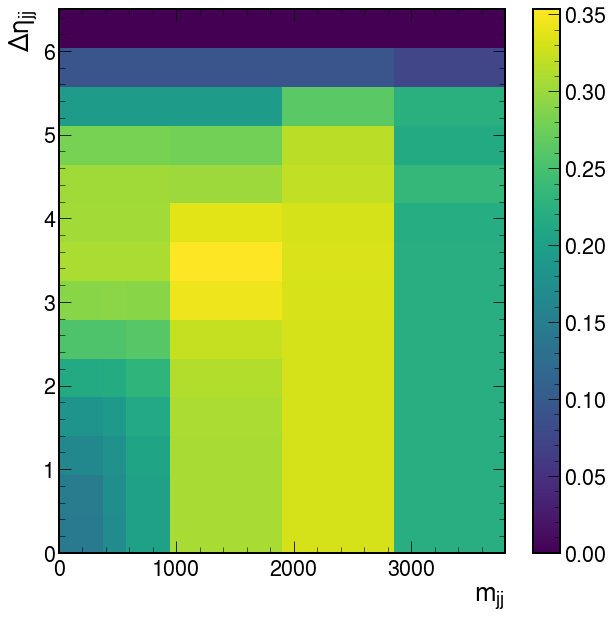

In [66]:
if year == '2017':

    cuts = []
    sigs = []

    deta_slices = [i*0.5 for i in range(0,14)]
    mjj_slices = [i*200 for i in range(0,20)]

    for deta in deta_slices:
        for mjj in mjj_slices:
            sliced = templates_window.integrate('deta',int_range=slice(deta,7)).integrate('mjj',int_range=slice(mjj,4000))
            s = sliced.values()[('VBF',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('ZH',)] + sliced.values()[('WH',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs += [significance(s,b)]
            cuts += [[mjj, deta]]
        
    cuts = np.array(cuts)
    print(max(sigs))
    print(cuts[np.argmax(sigs)])
    mjj_cut = cuts[np.argmax(sigs)][0]
    deta_cut = cuts[np.argmax(sigs)][1]

    plt.hist2d(cuts[:,0], cuts[:,1], density=False, weights=sigs, bins=[20,14]);
    plt.xlabel('$m_{jj}$');
    plt.ylabel('$\Delta\eta_{jj}$');
    plt.colorbar()
    plt.savefig(year+'/vbfsigs_2d.png')
    
else:
    mjj_cut = 1000.
    deta_cut = 3.5

In [67]:
# VBF significance
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

print(significance(s,b))
# this only makes sense in the mass window of Higgs

0.3534099121739666


In [68]:
df1 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['ggF','VBF','WH','ZH','ttH'])
df2 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['QCD','Wjets','Zjets','VV','ttbar','singlet'])

In [69]:
# deta cut
tmp = templates.sum('pt1','msd1','mjj','ddb1').integrate('deta',int_range=slice(deta_cut,7)).values()
cutname = '$\Delta\eta_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [70]:
# mjj cut
tmp = templates.sum('pt1','msd1','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).values()
cutname = '$m_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [71]:
#ddb cut
tmp = templates.sum('pt1','msd1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).integrate('ddb1',int_range=slice(0.89,1)).values()
cutname = 'DeepDoubleB'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [72]:
df1 = df1.astype('int')
df1.to_latex(buf=year+'/cutflow-sig.tex')

In [73]:
df2 = df2.astype('int')
df2.to_latex(buf=year+'/cutflow-bkg.tex')

                             QCD        Wjets       Zjets         VV  \
$\Delta\eta_{jj}$  228317.808024  4736.676617  2310.99534  70.259359   
$m_{jj}$           178045.046162   3728.99233  1844.58719  46.867128   
DeepDoubleB          3661.828231    84.267939  118.964257   3.443457   

                        ttbar     singlet  
$\Delta\eta_{jj}$  739.598491  172.967135  
$m_{jj}$           661.651637  140.414352  
DeepDoubleB         85.795879   22.010033  
